In [7]:
!unzip /content/data.zip


Streaming output truncated to the last 5000 lines.
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1035.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1036.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1037.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_104.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_105.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_106.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_107.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1072.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1073.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1074.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1075.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1076.jpg  
  inflating: dataset/Train/Engagement/cropped_face_0_frame_1077.jpg  
  inflating: dataset/Train/Engagement/cropp

In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import lite
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.metrics import Precision, Recall
from keras.models import load_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [23]:
batch_size = 64
image_height = 196
image_width = 196
epoch = 24
model_name = "Transfer-Learning-v1.keras"

In [24]:
train_path = '/content/dataset/Train'
test_path = '/content/dataset/Test'
val_path = '/content/dataset/Validation'

In [25]:
def plotting_images(item_dir, num_imgs=5):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(10, 10))
    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)
        img = plt.imread(img_path)
        plt.axis('off')
        plt.imshow(img)

    plt.tight_layout()

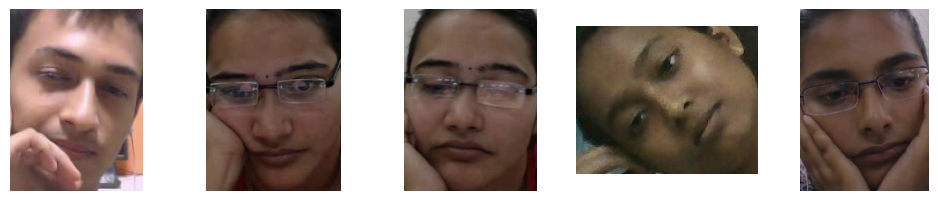

In [26]:
plotting_images("./dataset/Train/Boredom")

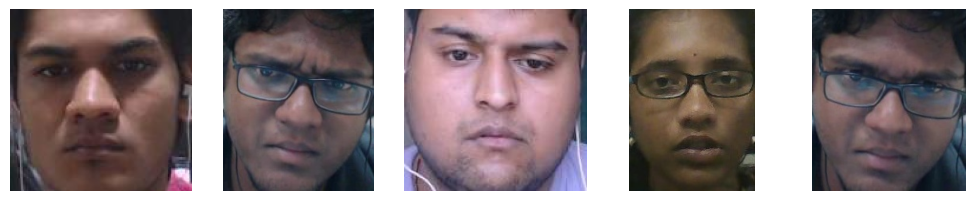

In [28]:
plotting_images("./dataset/Train/Confusion")

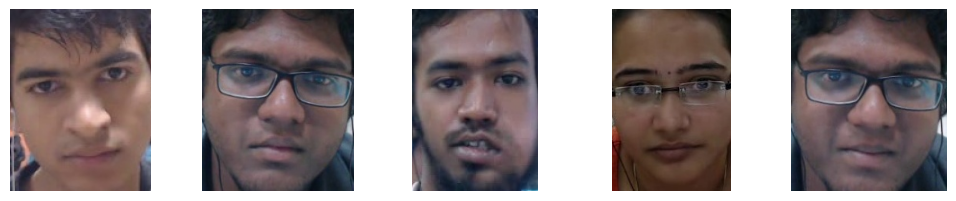

In [29]:
plotting_images("./dataset/Train/Engagement")

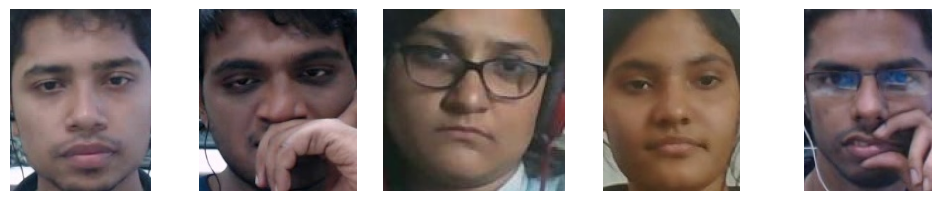

In [30]:
plotting_images("./dataset/Train/Frustration")

In [37]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [38]:
train_dataset = train_datagen.flow_from_directory(train_path,
                                                  target_size=(image_height, image_width),
                                                  color_mode='grayscale',
                                                  class_mode='categorical',
                                                  batch_size= batch_size,
                                                  )

test_dataset = test_datagen.flow_from_directory(test_path,
                                                target_size=(image_height, image_width),
                                                class_mode='categorical',
                                                color_mode='grayscale',
                                                batch_size= batch_size,
                                                shuffle=False
                                                )

valid_dataset = valid_datagen.flow_from_directory(val_path,
                                                  target_size=(image_height, image_width),
                                                  class_mode='categorical',
                                                  batch_size= batch_size,
                                                  color_mode='grayscale',
                                                  )

Found 7800 images belonging to 4 classes.
Found 2384 images belonging to 4 classes.
Found 1411 images belonging to 4 classes.


In [39]:
checkpoint = ModelCheckpoint(model_name, mode='auto', save_freq=1)

In [40]:
model = Sequential([

    Conv2D(32,(3,3),strides=(1, 1),activation='relu',padding='same', input_shape=train_dataset.image_shape),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64,(3,3),strides=(1, 1) ,padding='same',activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128,(3,3),strides=(1, 1),padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(4, activation='softmax')
])

In [41]:
METRICS = [
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)



In [ ]:
model_fit = model.fit(train_dataset,
                      validation_data=valid_dataset,
                      steps_per_epoch=12,
                      epochs = epoch,
                      callbacks=[checkpoint])

Epoch 1/24
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5380 - loss: 1.2255 - precision: 0.5121 - recall: 0.2936

In [21]:
model.save(model_name)

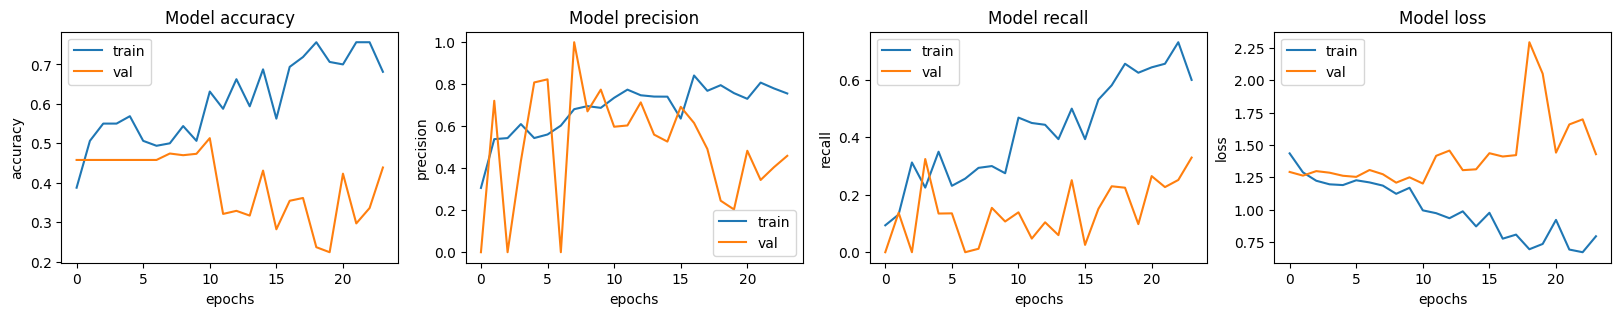

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy','precision','recall', 'loss']):
    ax[i].plot(model_fit.history[met])
    ax[i].plot(model_fit.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
predictions = model.predict(test_dataset)

149/149 [==============================] - 18s 117ms/step


In [ ]:
diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

In [ ]:
def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(5,5))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()

Accuracy: 0.7776845637583892
Precision: 0.471555599843833
Recall: 0.3489295514898522
F1_score: 0.31788882762683246


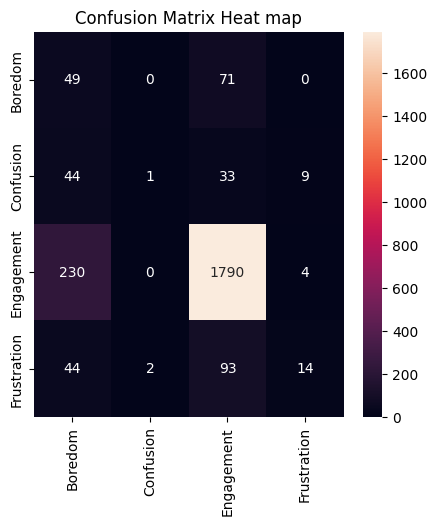

In [ ]:
evaluate(test_dataset.classes, predictions)

In [ ]:
model.evaluate(test_dataset)

149/149 [==============================] - 18s 121ms/step - loss: 0.7563 - accuracy: 0.7777 - precision: 0.7887 - recall: 0.7609


[0.7562941908836365,
 0.7776845693588257,
 0.7886956334114075,
 0.7609060406684875]